In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'LinearModel'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': None,
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class LinearModel(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define linear model
        self.TextModel = nn.Linear(25, 1)

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = LinearModel().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 26


In [13]:
# Do not train if already trained
if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
    # Load optimal weights and history
    model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
    history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
    print('Skipping training and loading optimal weights from previous training!')
else:
    # Train model
    model, history = sf.train_model(
        model=model,
        dataset_train=subsets['train'],
        dataset_val=subsets['val'],

        # Define loss & optimizer
        loss_function=nn.MSELoss().to(device),
        optimizer=torch.optim.SGD(model.parameters(), lr=.0001),

        # Define computing device
        device=device,

        # Define training parameters
        epochs=100,
        patience=100,
        delta=0,
        batch_size=64,
        shuffle=True,
        num_workers=0,
        pin_memory=True,

        # Define save locations
        save_state_dict_as=f'../models/{model_name}/state_dict.pt',
        save_history_as=f'../models/{model_name}/history.csv'
        )

100%|██████████| 646/646 [00:00<00:00, 3942.34it/s]


Epoch   1/100: RMSE_train: 1,668,654, RMSE_val: 1,608,619


100%|██████████| 646/646 [00:00<00:00, 4454.65it/s]


Epoch   2/100: RMSE_train: 1,564,749, RMSE_val: 1,508,382


100%|██████████| 646/646 [00:00<00:00, 4399.44it/s]


Epoch   3/100: RMSE_train: 1,486,147, RMSE_val: 1,448,761


100%|██████████| 646/646 [00:00<00:00, 4481.20it/s]


Epoch   4/100: RMSE_train: 1,423,451, RMSE_val: 1,388,633


100%|██████████| 646/646 [00:00<00:00, 4542.09it/s]


Epoch   5/100: RMSE_train: 1,373,179, RMSE_val: 1,359,304


100%|██████████| 646/646 [00:00<00:00, 4232.15it/s]


Epoch   6/100: RMSE_train: 1,332,888, RMSE_val: 1,335,389


100%|██████████| 646/646 [00:00<00:00, 4392.95it/s]


Epoch   7/100: RMSE_train: 1,300,996, RMSE_val: 1,312,366


100%|██████████| 646/646 [00:00<00:00, 4490.38it/s]


Epoch   8/100: RMSE_train: 1,275,384, RMSE_val: 1,304,527


100%|██████████| 646/646 [00:00<00:00, 4535.82it/s]


Epoch   9/100: RMSE_train: 1,255,111, RMSE_val: 1,295,875


100%|██████████| 646/646 [00:00<00:00, 4522.98it/s]


Epoch  10/100: RMSE_train: 1,239,247, RMSE_val: 1,292,419


100%|██████████| 646/646 [00:00<00:00, 4535.70it/s]


Epoch  11/100: RMSE_train: 1,226,670, RMSE_val: 1,295,885
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 4565.14it/s]


Epoch  12/100: RMSE_train: 1,216,781, RMSE_val: 1,297,463
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 4547.27it/s]


Epoch  13/100: RMSE_train: 1,209,102, RMSE_val: 1,302,329
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 4501.97it/s]


Epoch  14/100: RMSE_train: 1,202,927, RMSE_val: 1,311,088
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 4543.58it/s]


Epoch  15/100: RMSE_train: 1,198,066, RMSE_val: 1,314,631
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 4579.87it/s]


Epoch  16/100: RMSE_train: 1,194,457, RMSE_val: 1,329,912
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:00<00:00, 4539.23it/s]


Epoch  17/100: RMSE_train: 1,191,383, RMSE_val: 1,331,392
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:00<00:00, 3832.72it/s]


Epoch  18/100: RMSE_train: 1,188,941, RMSE_val: 1,348,559
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:00<00:00, 4575.30it/s]


Epoch  19/100: RMSE_train: 1,186,982, RMSE_val: 1,349,619
EarlyStopping counter: 9 out of 100


100%|██████████| 646/646 [00:00<00:00, 4507.49it/s]


Epoch  20/100: RMSE_train: 1,185,454, RMSE_val: 1,360,131
EarlyStopping counter: 10 out of 100


100%|██████████| 646/646 [00:00<00:00, 4427.56it/s]


Epoch  21/100: RMSE_train: 1,184,290, RMSE_val: 1,373,403
EarlyStopping counter: 11 out of 100


100%|██████████| 646/646 [00:00<00:00, 4555.19it/s]


Epoch  22/100: RMSE_train: 1,183,281, RMSE_val: 1,379,424
EarlyStopping counter: 12 out of 100


100%|██████████| 646/646 [00:00<00:00, 4587.80it/s]


Epoch  23/100: RMSE_train: 1,182,384, RMSE_val: 1,390,229
EarlyStopping counter: 13 out of 100


100%|██████████| 646/646 [00:00<00:00, 4555.52it/s]


Epoch  24/100: RMSE_train: 1,181,743, RMSE_val: 1,398,679
EarlyStopping counter: 14 out of 100


100%|██████████| 646/646 [00:00<00:00, 4629.32it/s]


Epoch  25/100: RMSE_train: 1,181,132, RMSE_val: 1,414,467
EarlyStopping counter: 15 out of 100


100%|██████████| 646/646 [00:00<00:00, 4523.72it/s]


Epoch  26/100: RMSE_train: 1,180,758, RMSE_val: 1,418,679
EarlyStopping counter: 16 out of 100


100%|██████████| 646/646 [00:00<00:00, 4571.45it/s]


Epoch  27/100: RMSE_train: 1,180,195, RMSE_val: 1,425,988
EarlyStopping counter: 17 out of 100


100%|██████████| 646/646 [00:00<00:00, 4524.09it/s]


Epoch  28/100: RMSE_train: 1,180,001, RMSE_val: 1,435,395
EarlyStopping counter: 18 out of 100


100%|██████████| 646/646 [00:00<00:00, 4615.80it/s]


Epoch  29/100: RMSE_train: 1,179,508, RMSE_val: 1,447,826
EarlyStopping counter: 19 out of 100


100%|██████████| 646/646 [00:00<00:00, 4132.28it/s]


Epoch  30/100: RMSE_train: 1,179,377, RMSE_val: 1,454,257
EarlyStopping counter: 20 out of 100


100%|██████████| 646/646 [00:00<00:00, 4477.10it/s]


Epoch  31/100: RMSE_train: 1,179,049, RMSE_val: 1,462,670
EarlyStopping counter: 21 out of 100


100%|██████████| 646/646 [00:00<00:00, 4430.94it/s]


Epoch  32/100: RMSE_train: 1,178,949, RMSE_val: 1,470,690
EarlyStopping counter: 22 out of 100


100%|██████████| 646/646 [00:00<00:00, 4513.81it/s]


Epoch  33/100: RMSE_train: 1,178,791, RMSE_val: 1,494,066
EarlyStopping counter: 23 out of 100


100%|██████████| 646/646 [00:00<00:00, 4576.47it/s]


Epoch  34/100: RMSE_train: 1,178,472, RMSE_val: 1,495,257
EarlyStopping counter: 24 out of 100


100%|██████████| 646/646 [00:00<00:00, 4568.92it/s]


Epoch  35/100: RMSE_train: 1,178,420, RMSE_val: 1,498,656
EarlyStopping counter: 25 out of 100


100%|██████████| 646/646 [00:00<00:00, 4681.39it/s]


Epoch  36/100: RMSE_train: 1,178,139, RMSE_val: 1,504,353
EarlyStopping counter: 26 out of 100


100%|██████████| 646/646 [00:00<00:00, 4503.85it/s]


Epoch  37/100: RMSE_train: 1,178,007, RMSE_val: 1,514,148
EarlyStopping counter: 27 out of 100


100%|██████████| 646/646 [00:00<00:00, 4537.74it/s]


Epoch  38/100: RMSE_train: 1,177,881, RMSE_val: 1,526,355
EarlyStopping counter: 28 out of 100


100%|██████████| 646/646 [00:00<00:00, 4594.27it/s]


Epoch  39/100: RMSE_train: 1,177,694, RMSE_val: 1,528,425
EarlyStopping counter: 29 out of 100


100%|██████████| 646/646 [00:00<00:00, 4642.88it/s]


Epoch  40/100: RMSE_train: 1,177,659, RMSE_val: 1,537,905
EarlyStopping counter: 30 out of 100


100%|██████████| 646/646 [00:00<00:00, 4588.39it/s]


Epoch  41/100: RMSE_train: 1,177,483, RMSE_val: 1,543,683
EarlyStopping counter: 31 out of 100


100%|██████████| 646/646 [00:00<00:00, 4575.33it/s]


Epoch  42/100: RMSE_train: 1,177,330, RMSE_val: 1,550,780
EarlyStopping counter: 32 out of 100


100%|██████████| 646/646 [00:00<00:00, 3682.82it/s]


Epoch  43/100: RMSE_train: 1,177,284, RMSE_val: 1,559,702
EarlyStopping counter: 33 out of 100


100%|██████████| 646/646 [00:00<00:00, 4547.38it/s]


Epoch  44/100: RMSE_train: 1,177,205, RMSE_val: 1,565,796
EarlyStopping counter: 34 out of 100


100%|██████████| 646/646 [00:00<00:00, 4648.45it/s]


Epoch  45/100: RMSE_train: 1,177,083, RMSE_val: 1,571,765
EarlyStopping counter: 35 out of 100


100%|██████████| 646/646 [00:00<00:00, 4543.13it/s]


Epoch  46/100: RMSE_train: 1,177,067, RMSE_val: 1,585,265
EarlyStopping counter: 36 out of 100


100%|██████████| 646/646 [00:00<00:00, 4573.78it/s]


Epoch  47/100: RMSE_train: 1,176,846, RMSE_val: 1,593,853
EarlyStopping counter: 37 out of 100


100%|██████████| 646/646 [00:00<00:00, 4532.48it/s]


Epoch  48/100: RMSE_train: 1,176,729, RMSE_val: 1,593,009
EarlyStopping counter: 38 out of 100


100%|██████████| 646/646 [00:00<00:00, 4469.81it/s]


Epoch  49/100: RMSE_train: 1,176,646, RMSE_val: 1,598,412
EarlyStopping counter: 39 out of 100


100%|██████████| 646/646 [00:00<00:00, 4628.87it/s]


Epoch  50/100: RMSE_train: 1,176,668, RMSE_val: 1,608,215
EarlyStopping counter: 40 out of 100


100%|██████████| 646/646 [00:00<00:00, 4521.21it/s]


Epoch  51/100: RMSE_train: 1,176,636, RMSE_val: 1,612,273
EarlyStopping counter: 41 out of 100


100%|██████████| 646/646 [00:00<00:00, 4447.81it/s]


Epoch  52/100: RMSE_train: 1,176,563, RMSE_val: 1,616,365
EarlyStopping counter: 42 out of 100


100%|██████████| 646/646 [00:00<00:00, 4507.21it/s]


Epoch  53/100: RMSE_train: 1,176,536, RMSE_val: 1,624,179
EarlyStopping counter: 43 out of 100


100%|██████████| 646/646 [00:00<00:00, 4444.82it/s]


Epoch  54/100: RMSE_train: 1,176,449, RMSE_val: 1,627,287
EarlyStopping counter: 44 out of 100


100%|██████████| 646/646 [00:00<00:00, 3926.07it/s]


Epoch  55/100: RMSE_train: 1,176,286, RMSE_val: 1,633,126
EarlyStopping counter: 45 out of 100


100%|██████████| 646/646 [00:00<00:00, 4553.78it/s]


Epoch  56/100: RMSE_train: 1,176,169, RMSE_val: 1,653,013
EarlyStopping counter: 46 out of 100


100%|██████████| 646/646 [00:00<00:00, 4522.48it/s]


Epoch  57/100: RMSE_train: 1,176,293, RMSE_val: 1,642,810
EarlyStopping counter: 47 out of 100


100%|██████████| 646/646 [00:00<00:00, 4535.65it/s]


Epoch  58/100: RMSE_train: 1,176,147, RMSE_val: 1,648,254
EarlyStopping counter: 48 out of 100


100%|██████████| 646/646 [00:00<00:00, 4491.11it/s]


Epoch  59/100: RMSE_train: 1,175,982, RMSE_val: 1,656,824
EarlyStopping counter: 49 out of 100


100%|██████████| 646/646 [00:00<00:00, 4466.58it/s]


Epoch  60/100: RMSE_train: 1,176,039, RMSE_val: 1,664,301
EarlyStopping counter: 50 out of 100


100%|██████████| 646/646 [00:00<00:00, 4578.18it/s]


Epoch  61/100: RMSE_train: 1,176,002, RMSE_val: 1,662,757
EarlyStopping counter: 51 out of 100


100%|██████████| 646/646 [00:00<00:00, 4450.65it/s]


Epoch  62/100: RMSE_train: 1,176,120, RMSE_val: 1,669,358
EarlyStopping counter: 52 out of 100


100%|██████████| 646/646 [00:00<00:00, 4501.56it/s]


Epoch  63/100: RMSE_train: 1,175,893, RMSE_val: 1,672,489
EarlyStopping counter: 53 out of 100


100%|██████████| 646/646 [00:00<00:00, 4645.31it/s]


Epoch  64/100: RMSE_train: 1,175,837, RMSE_val: 1,676,280
EarlyStopping counter: 54 out of 100


100%|██████████| 646/646 [00:00<00:00, 4453.55it/s]


Epoch  65/100: RMSE_train: 1,175,740, RMSE_val: 1,683,278
EarlyStopping counter: 55 out of 100


100%|██████████| 646/646 [00:00<00:00, 3811.70it/s]


Epoch  66/100: RMSE_train: 1,175,690, RMSE_val: 1,684,095
EarlyStopping counter: 56 out of 100


100%|██████████| 646/646 [00:00<00:00, 4634.45it/s]


Epoch  67/100: RMSE_train: 1,175,608, RMSE_val: 1,689,009
EarlyStopping counter: 57 out of 100


100%|██████████| 646/646 [00:00<00:00, 4550.66it/s]


Epoch  68/100: RMSE_train: 1,175,641, RMSE_val: 1,702,400
EarlyStopping counter: 58 out of 100


100%|██████████| 646/646 [00:00<00:00, 4549.59it/s]


Epoch  69/100: RMSE_train: 1,175,501, RMSE_val: 1,702,781
EarlyStopping counter: 59 out of 100


100%|██████████| 646/646 [00:00<00:00, 4525.23it/s]


Epoch  70/100: RMSE_train: 1,175,537, RMSE_val: 1,702,884
EarlyStopping counter: 60 out of 100


100%|██████████| 646/646 [00:00<00:00, 4532.03it/s]


Epoch  71/100: RMSE_train: 1,175,473, RMSE_val: 1,705,362
EarlyStopping counter: 61 out of 100


100%|██████████| 646/646 [00:00<00:00, 4572.87it/s]


Epoch  72/100: RMSE_train: 1,175,383, RMSE_val: 1,709,714
EarlyStopping counter: 62 out of 100


100%|██████████| 646/646 [00:00<00:00, 4572.51it/s]


Epoch  73/100: RMSE_train: 1,175,411, RMSE_val: 1,712,231
EarlyStopping counter: 63 out of 100


100%|██████████| 646/646 [00:00<00:00, 4529.49it/s]


Epoch  74/100: RMSE_train: 1,175,449, RMSE_val: 1,718,198
EarlyStopping counter: 64 out of 100


100%|██████████| 646/646 [00:00<00:00, 4560.32it/s]


Epoch  75/100: RMSE_train: 1,175,367, RMSE_val: 1,721,224
EarlyStopping counter: 65 out of 100


100%|██████████| 646/646 [00:00<00:00, 4510.01it/s]


Epoch  76/100: RMSE_train: 1,175,305, RMSE_val: 1,726,166
EarlyStopping counter: 66 out of 100


100%|██████████| 646/646 [00:00<00:00, 4567.43it/s]


Epoch  77/100: RMSE_train: 1,175,292, RMSE_val: 1,729,228
EarlyStopping counter: 67 out of 100


100%|██████████| 646/646 [00:00<00:00, 4493.91it/s]


Epoch  78/100: RMSE_train: 1,175,261, RMSE_val: 1,736,043
EarlyStopping counter: 68 out of 100


100%|██████████| 646/646 [00:00<00:00, 3798.01it/s]


Epoch  79/100: RMSE_train: 1,175,218, RMSE_val: 1,732,063
EarlyStopping counter: 69 out of 100


100%|██████████| 646/646 [00:00<00:00, 4505.64it/s]


Epoch  80/100: RMSE_train: 1,175,253, RMSE_val: 1,736,719
EarlyStopping counter: 70 out of 100


100%|██████████| 646/646 [00:00<00:00, 4573.06it/s]


Epoch  81/100: RMSE_train: 1,175,350, RMSE_val: 1,741,438
EarlyStopping counter: 71 out of 100


100%|██████████| 646/646 [00:00<00:00, 4563.28it/s]


Epoch  82/100: RMSE_train: 1,175,385, RMSE_val: 1,740,714
EarlyStopping counter: 72 out of 100


100%|██████████| 646/646 [00:00<00:00, 4486.42it/s]


Epoch  83/100: RMSE_train: 1,175,047, RMSE_val: 1,743,156
EarlyStopping counter: 73 out of 100


100%|██████████| 646/646 [00:00<00:00, 4513.85it/s]


Epoch  84/100: RMSE_train: 1,175,155, RMSE_val: 1,745,639
EarlyStopping counter: 74 out of 100


100%|██████████| 646/646 [00:00<00:00, 4542.62it/s]


Epoch  85/100: RMSE_train: 1,175,174, RMSE_val: 1,750,147
EarlyStopping counter: 75 out of 100


100%|██████████| 646/646 [00:00<00:00, 4568.76it/s]


Epoch  86/100: RMSE_train: 1,175,127, RMSE_val: 1,752,632
EarlyStopping counter: 76 out of 100


100%|██████████| 646/646 [00:00<00:00, 4539.78it/s]


Epoch  87/100: RMSE_train: 1,174,967, RMSE_val: 1,753,755
EarlyStopping counter: 77 out of 100


100%|██████████| 646/646 [00:00<00:00, 4580.58it/s]


Epoch  88/100: RMSE_train: 1,174,953, RMSE_val: 1,761,085
EarlyStopping counter: 78 out of 100


100%|██████████| 646/646 [00:00<00:00, 4579.18it/s]


Epoch  89/100: RMSE_train: 1,174,894, RMSE_val: 1,762,733
EarlyStopping counter: 79 out of 100


100%|██████████| 646/646 [00:00<00:00, 4580.10it/s]


Epoch  90/100: RMSE_train: 1,174,935, RMSE_val: 1,765,700
EarlyStopping counter: 80 out of 100


100%|██████████| 646/646 [00:00<00:00, 4500.01it/s]


Epoch  91/100: RMSE_train: 1,174,835, RMSE_val: 1,763,569
EarlyStopping counter: 81 out of 100


100%|██████████| 646/646 [00:00<00:00, 4265.74it/s]


Epoch  92/100: RMSE_train: 1,174,870, RMSE_val: 1,765,893
EarlyStopping counter: 82 out of 100


100%|██████████| 646/646 [00:00<00:00, 4586.24it/s]


Epoch  93/100: RMSE_train: 1,174,965, RMSE_val: 1,772,057
EarlyStopping counter: 83 out of 100


100%|██████████| 646/646 [00:00<00:00, 4537.28it/s]


Epoch  94/100: RMSE_train: 1,174,806, RMSE_val: 1,770,169
EarlyStopping counter: 84 out of 100


100%|██████████| 646/646 [00:00<00:00, 4664.96it/s]


Epoch  95/100: RMSE_train: 1,174,957, RMSE_val: 1,776,447
EarlyStopping counter: 85 out of 100


100%|██████████| 646/646 [00:00<00:00, 4610.80it/s]


Epoch  96/100: RMSE_train: 1,174,930, RMSE_val: 1,775,640
EarlyStopping counter: 86 out of 100


100%|██████████| 646/646 [00:00<00:00, 4554.59it/s]


Epoch  97/100: RMSE_train: 1,174,689, RMSE_val: 1,777,000
EarlyStopping counter: 87 out of 100


100%|██████████| 646/646 [00:00<00:00, 4613.06it/s]


Epoch  98/100: RMSE_train: 1,174,687, RMSE_val: 1,778,225
EarlyStopping counter: 88 out of 100


100%|██████████| 646/646 [00:00<00:00, 4538.69it/s]


Epoch  99/100: RMSE_train: 1,174,659, RMSE_val: 1,780,288
EarlyStopping counter: 89 out of 100


100%|██████████| 646/646 [00:00<00:00, 4560.34it/s]

Epoch 100/100: RMSE_train: 1,174,681, RMSE_val: 1,781,323
EarlyStopping counter: 90 out of 100


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset         RMSE         MAE   MAPE      R2
----------------------------------------------
train   1232435.526  702051.370  0.866   0.026
val     1296483.869  694178.138  0.905  -0.097
test    1223777.870  691906.883  0.839   0.032
----------------------------------------------
total   1237271.212  699235.264  0.865   0.015


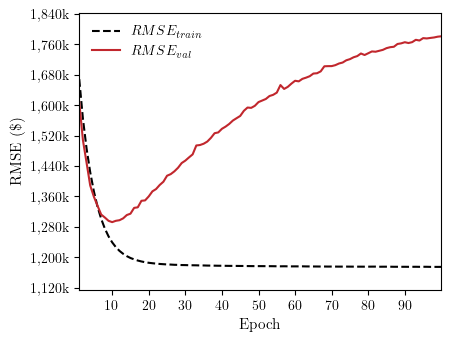

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

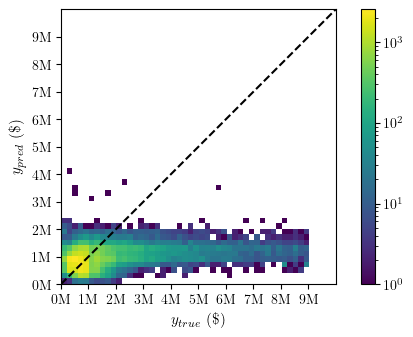

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')